In [4]:
import sys
import importlib
def reload_modules(*modules):
    for module in modules:
        if module.__name__ in sys.modules:
            importlib.reload(module)
        else:
            print(f"Module {module.__name__} is not currently imported.")

import numpy as np
import time
import copy
from PIL import Image
import cv2
import open3d as o3d
import importlib
import imutils
import matplotlib.pyplot as plt
from magpie_perception import pcd
from magpie_perception import utils
from magpie_perception.utils import label_wrist_image, find_object, label_wrist_image_rotation_axes
from magpie_control import realsense_wrapper as real
from magpie_control import ur5
from magpie_control import gripper
from magpie_control import poses
import spatialmath as sm
reload_modules(pcd, utils, real, ur5, gripper)

# with help from: https://github.com/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb
import os
from google import genai
import openai
from dotenv import load_dotenv
import instructor
from magpie_prompts.prompts import sf_force_thinker, sf_grasp_selection, sf_force_reflection, sf_position_thinker
from magpie_prompts import conversation
from magpie_prompts.conversation import openai_encode_image, build_messages, send_message
reload_modules(sf_force_thinker, sf_grasp_selection, sf_position_thinker, conversation, sf_force_reflection)

load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
OPENAI_API_KEY = os.getenv('CORRELL_API_KEY')
GEMINI_MODEL_ID = "gemini-2.0-flash" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true}
# OPENAI_MODEL_ID = "gpt-4o-mini"
OPENAI_MODEL_ID = "gpt-4.1"

gemini_client = genai.Client(api_key=GEMINI_API_KEY)
openai_client = openai.OpenAI(api_key=OPENAI_API_KEY)
force_thinker = sf_force_thinker.PromptForceThinker()

In [3]:
devices = real.poll_devices()
print(devices)
wrist = real.RealSense(fps=15, w=640, h=480, device_name="D405")
wrist.initConnection(device_serial=devices['D405'])
wkspc = real.RealSense(zMax=5, fps=6, w=640, h=480, device_name="D435")
wkspc.initConnection(device_serial=devices['D435'])

{'D435': '832412070344', 'D405': '126122270157'}
There are 2 available devices!
There are 2 available devices!


In [5]:
ROBOT_IP = "192.168.0.4"
robot = ur5.UR5_Interface(ROBOT_IP, 
                            freq=6, # 6Hz frequency
                            record=False,
                            provide_gripper=True,
                            provide_ft_sensor=True,)
robot.start()
robot.start_ft_sensor()

Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate


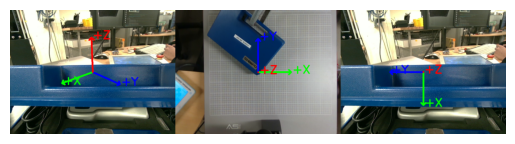

In [87]:
pcd_wkspc, rgbd_wkspc = wkspc.getPCD()
pcd_wrist, rgbd_wrist = wrist.getPCD()
img_wrist = np.array(rgbd_wrist.color)
img_wkspc = np.array(rgbd_wkspc.color)

R_cw = np.array([ # camera to wrist
    [0, -1, 0],
    [1,  0, 0],
    [0,  0, 1]
])
R_wkspc = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
T_wr = np.array(robot.getPose())
R_wr = T_wr[:3, :3]
R_cr = R_cw @ R_wr.T
intrinsics = np.load("intrinsic_matrix.npy", allow_pickle=True)
img_wrist_labeled = label_wrist_image_rotation_axes(img_wrist.copy(), R_cw, intrinsics, axis_length=0.03)
img_wrist_labeled_base = label_wrist_image_rotation_axes(img_wrist.copy(), R_cr, intrinsics, axis_length=0.03)
img_wkspc_labeled = label_wrist_image_rotation_axes(img_wkspc.copy(), R_wkspc, intrinsics, axis_length=0.03)
world_only = np.hstack((img_wrist_labeled_base, img_wkspc_labeled))
wrist_only = np.hstack((img_wkspc, img_wrist_labeled))
tri_img = np.hstack((img_wrist_labeled_base, img_wkspc_labeled, img_wrist_labeled))
# final_img = np.hstack((wrist_img_labeled, wrist_img2_labeled, ))

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(tri_img)


In [91]:
prompt_config = {
"obj": "blue case top lid handle",
"task": "open the blue case",
}
model_type = "gemini"
# model_type = "openai"

In [92]:
reload_modules(sf_force_thinker, sf_grasp_selection, sf_position_thinker, conversation, sf_force_reflection)
from magpie_prompts.conversation import openai_encode_image, build_messages, send_message

POSITION_MESSAGES, POSITION_RESPONSES, POSITION_MOTION_PLANS = [], [], []
client, model = None, None
if model_type == "openai":
    client = openai_client
    model = "gpt-4.1-mini"
    # model = OPENAI_MODEL_ID
elif model_type == "gemini":
    client = gemini_client
    model = GEMINI_MODEL_ID

img = Image.fromarray(world_only)
# prompt = sf_force_thinker.prompt_motion_thinker.format(**prompt_config)
prompt = sf_position_thinker.prompt_position_thinker.format(**prompt_config)
POSITION_MESSAGES = build_messages(prompt, img, messages=POSITION_MESSAGES, model_type=model_type)
response = send_message(client, model, POSITION_MESSAGES, model_type=model_type)
position_motion_plan = force_thinker.process_thinker_response(response)
print(response)
POSITION_MESSAGES = build_messages(response, image=None, messages=POSITION_MESSAGES, model_type=model_type, role="assistant")
POSITION_RESPONSES = build_messages(response, image=None, messages=POSITION_RESPONSES, model_type=model_type)
POSITION_MOTION_PLANS = build_messages(position_motion_plan, image=None, messages=POSITION_MOTION_PLANS, model_type=model_type)
position_motion_plan

[start of position motion plan]
The task is to open the blue case while grasping the blue case top lid handle.

Aligning Images With World Frame Motion:
The provided images in the two-part image confirm the presence of a blue case with a handle on its lid, positioned on a table, and the robot has the end-effector capable of grasping the handle. The case appears to be made of a rigid plastic material.
The red axis representing the world Z-axis corresponds to upward (positive) and downward (negative) motion in the world. 
To complete the task, the object in the image must perform upward and positive motion along the Z-axis with magnitude 0.15 meters.
The green axis representing the world X-axis corresponds to left (positive) and right (negative) motion in the world, relative to the robot. 
To complete the task, the object in the image must perform no motion along the X-axis with magnitude 0.0 meters.
The blue axis representing the world Y-axis corresponds to backward (positive) and forwa

{'world_motion_description': 'Lift the blue case lid by moving it upwards along the Z-axis, after gripping it.',
 'world_motion_direction': [0, 0, 1],
 'world_motion_magnitude': [0.0, 0.0, 0.15],
 'world_motion_vector': [0.0, 0.0, 0.15]}

In [89]:
pose = robot.getPose().A
R = pose[:3, :3]
p_world = np.array(position_motion_plan["world_motion_vector"])
p_wrist = p_world @ R
position_motion_plan["wrist_motion_vector"] = list(p_wrist.round(4))
# combine prompt_config dict with position_motion_plan dict
position_motion_plan_combined = {**prompt_config, **position_motion_plan}
position_motion_plan_combined

{'obj': 'blue case top lid handle',
 'task': 'open the blue case',
 'world_motion_description': 'The blue case lid handle moves upward along the Z-axis to open the lid, no lateral motion along X or Y axes is required.',
 'world_motion_direction': [0, 0, 1],
 'world_motion_magnitude': [0.0, 0.0, 0.15],
 'world_motion_vector': [0.0, 0.0, 0.15],
 'wrist_motion_vector': [-0.1376, 0.005, -0.0594]}

In [93]:
reload_modules(sf_force_thinker, sf_grasp_selection, sf_position_thinker, conversation, sf_force_reflection)
from magpie_prompts.conversation import openai_encode_image, build_messages, send_message

WRENCH_MESSAGES, WRENCH_RESPONSES, WRENCH_MOTION_PLANS = [], [], []

wrench_prompt_config = position_motion_plan_combined.copy()

img = Image.fromarray(tri_img)
prompt = sf_force_thinker.prompt_force_thinker.format(**wrench_prompt_config)
WRENCH_MESSAGES = build_messages(prompt, img, messages=WRENCH_MESSAGES, model_type=model_type)
response = send_message(client, model, WRENCH_MESSAGES, model_type=model_type)
wrench_motion_plan = force_thinker.process_thinker_response(response)
print(response)
WRENCH_MESSAGES = build_messages(response, image=None, messages=WRENCH_MESSAGES, model_type=model_type, role="assistant")
WRENCH_RESPONSES = build_messages(response, image=None, messages=WRENCH_RESPONSES, model_type=model_type)
WRENCH_MOTION_PLANS = build_messages(wrench_motion_plan, image=None, messages=WRENCH_MOTION_PLANS, model_type=model_type)
wrench_motion_plan

[start of wrench plan]
Aligning Image With Motion:
The task is to open the blue case while grasping the blue case top lid handle.
The world frame motion to accomplish this task is [0.0, 0.0, 0.15] (x, y, z in meters) because The blue case lid handle moves upward along the Z-axis to open the lid, no lateral motion along X or Y axes is required..
Using the robot pose data, this world motion resolves to the following positional motion along wrist frame: [-0.1376, 0.005, -0.0594].
In the right image with the labeled wrist axes, the center red dot into the page represents motion along the wrist Z-axis. That is why, based off knowledge of the task and motion in the world frame the the motion along the wrist Z-axis is -0.0594, since the object's required motion in the wrist frame to accomplish the task is slight motion inward (along the negative wrist Z-axis).
Then, the green axis represents motion along the wrist's X-axis. That is why, based off knowledge of the task and motion in the world 

{'wrench_description': 'Forces and torques required to lift and pull the blue case lid open, considering gravity and hinge resistance.',
 'wrench': [-2.0, 0.5, -2.0, 0.0, 0.25, 0.0],
 'grasp_force': 7.5,
 'duration': 3.0}

In [9]:
robot.toggle_teach_mode()